In [20]:
from variables import filenames, features, target
from load_dataset import load
from pre_processing import apply
import polars as pl
import numpy as np

In [21]:
df = load(filenames)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [22]:
missing_val = df.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [23]:
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s       1211
 Flow Packets/s    1564
dtype: int64


In [24]:
print(f'Initial missing values: {df.isna().sum().sum()}')

df.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {df.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3128


In [25]:
missing = df.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s       1564
 Flow Packets/s    1564
dtype: int64


In [26]:
df.columns = df.columns.str.strip()
select_colums = ["Destination Port", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Flow Duration", "Flow Packets/s", "Flow Bytes/s", "Down/Up Ratio", "Label"]
df = df[select_colums]
df.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Label
0,54865,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN
1,55054,1,1,6,6,109,18348.62385,1.100917e+05,1,BENIGN
2,55055,1,1,6,6,52,38461.53846,2.307692e+05,1,BENIGN
3,46236,1,1,6,6,34,58823.52941,3.529412e+05,1,BENIGN
4,54863,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN


In [28]:
df["Label"].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [ ]:
df["Class"] = (df["Label"] != "BENIGN").astype(int)
df.drop(["Label"], axis=1 ,inplace=True)
df.head()

In [51]:
X = df.iloc[:, :8]
y = df["Class"]

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

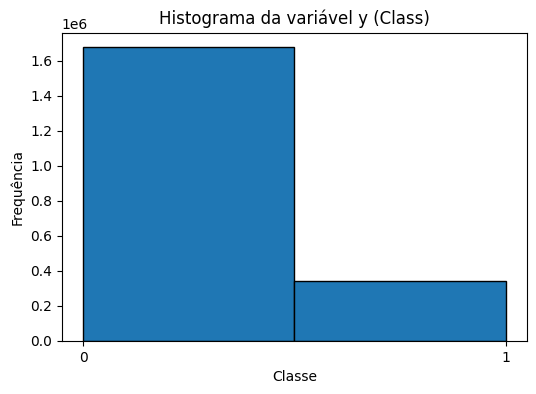

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(y_train, bins=2, edgecolor='black')
plt.title('Histograma da variável y (Class)')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks([0, 1])
plt.show()

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import time

class VerboseRandomForest(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        print(f"Iniciando treinamento com {self.n_estimators} árvores...")
        start = time.time()
        for i in tqdm(range(self.n_estimators), desc="Treinando árvores"):
            self.set_params(warm_start=True, n_estimators=i+1)
            super().fit(X, y, sample_weight)
        end = time.time()
        print(f"Treinamento concluído em {end - start:.2f} segundos")
        return self

# Uso
randomForest = VerboseRandomForest(random_state=42, n_jobs=-1, n_estimators=100, warm_start=True)
randomForest.fit(X_train_scaled, y_train)


Iniciando treinamento com 100 árvores...


Treinando árvores: 100%|██████████| 100/100 [04:31<00:00,  2.71s/it]

Treinamento concluído em 271.43 segundos


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
y_predict = randomForest.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score, recall_score, accuracy_score
metrics = r2_score(y_test, y_predict)
print(metrics)

0.972497961697489


In [79]:
from sklearn.metrics import r2_score, recall_score, accuracy_score
metrics_accuracy = accuracy_score(y_test, y_predict)
print(metrics_accuracy)

0.9961405268468283


In [ ]:
from sklearn.metrics import r2_score, recall_score, f1_score
metrics_recall = recall_score(y_test, y_predict)
print(metrics_recall)

0.987778247393632


In [72]:
from sklearn.metrics import r2_score, recall_score, f1_score
metrics_f1 = f1_score(y_test, y_predict)
print(metrics_f1)

0.9885616595287192


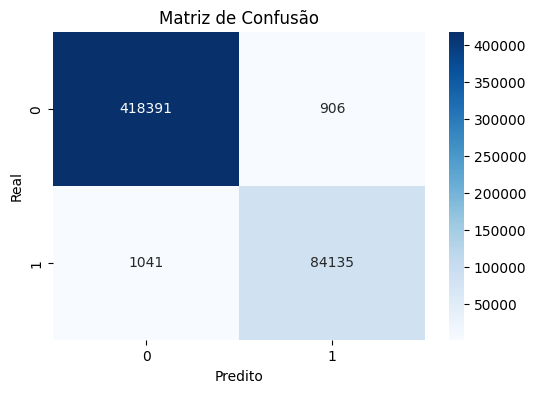

In [82]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Matriz de Confusão"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_predict, labels=[0, 1])